# Import Data and Dependencies

In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context('notebook',font_scale=1.25)
from IPython.core.display import HTML,display
import scipy.stats
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D

In [39]:
df=pd.read_csv('Mall_Customers.csv')


In [43]:
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,1,19,15,39
1,2,1,21,15,81
2,3,0,20,16,6
3,4,0,23,16,77
4,5,0,31,17,40


In [42]:
df['Gender'] = df['Gender'].apply(lambda x: 1 if x=="Male" else 0)

In [46]:
df = df.rename({'CustomerID': "ID",'Annual Income (k$)': "Income","Spending Score (1-100)":'Score'}, axis='columns')

# EDA

- Age is Right skewed, Income and Score are Roughly Normally Distributed.


In [4]:
# CHECK NA VALUES
df.isna().sum()

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

In [44]:
round(df.describe().T,2)

,count,mean,std,min,25%,50%,75%,max
CustomerID,200.0,100.50,57.88,1.0,50.75,100.5,150.25,200.0
Gender,200.0,0.44,0.50,0.0,0.00,0.0,1.00,1.0
Age,200.0,38.85,13.97,18.0,28.75,36.0,49.00,70.0
Annual Income (k$),200.0,60.56,26.26,15.0,41.50,61.5,78.00,137.0
Spending Score (1-100),200.0,50.20,25.82,1.0,34.75,50.0,73.00,99.0


In [47]:
df.drop(["ID"],axis=1,inplace=True)

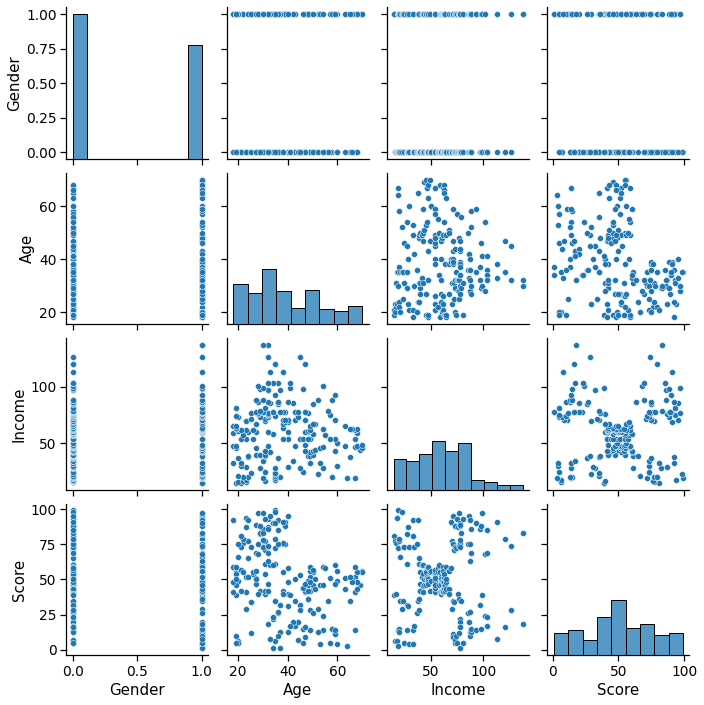

In [51]:
sns.pairplot(df)

## Bivariate Analysis

### Checking for Association between Gender and Score/Income


* <b> Stating the hypothesis:</b>

>  **H0:Gender and Score (Income) are independent.**

>  **H1:Score (Income) depends on Gender.**

Since the p-value > 0.05, we fail to reject H0 hypothsis. Therefore, Score and Annual income are independent of Gender

In [57]:
cols = ['Income','Score']
for i in cols:
    cont_table= pd.crosstab(df['Gender'],df[i])
    _,p_value,_,_=scipy.stats.chi2_contingency(cont_table,correction=True)
    print(f"p-value for the'{i}'':{p_value:.4f}")

p-value for the'Income'':0.3495
p-value for the'Score'':0.3412


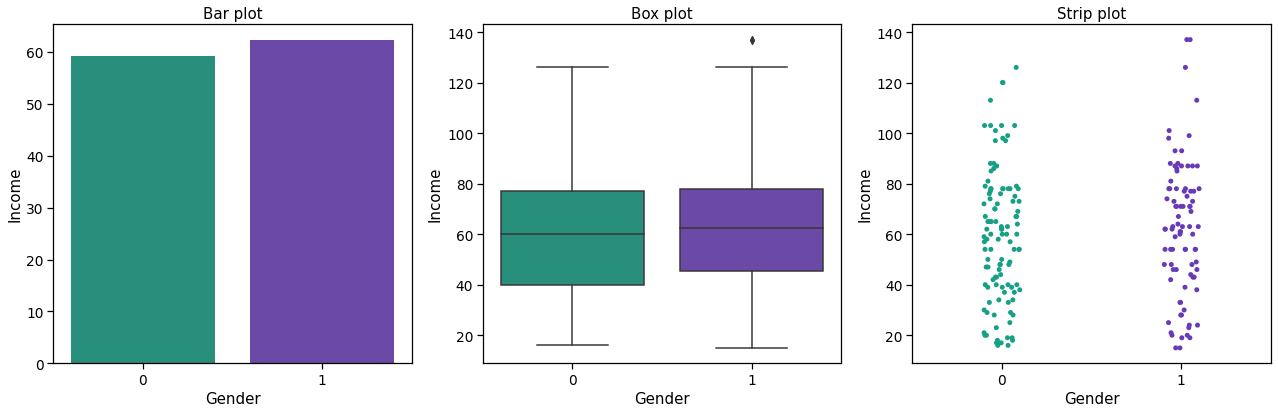

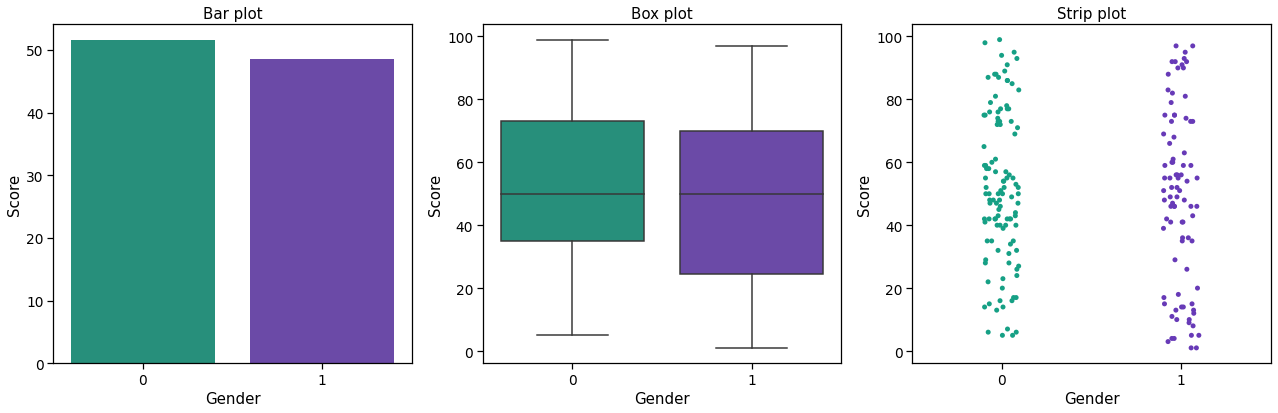

In [60]:
for i, col in enumerate (cols):
    fig=plt.figure(figsize=(18,6))
    ax=plt.subplot(1,3,1)
    temp=df.groupby('Gender')[col].mean().reset_index()
    sns.barplot(data=temp,x='Gender',y=col,palette=['#16A085','#673AB7']);
    plt.title("Bar plot",fontsize=15)
    ax=plt.subplot(1,3,2)
    sns.boxplot(data=df,x='Gender',y=col,palette=['#16A085','#673AB7']);
    plt.title("Box plot",fontsize=15)

    ax=plt.subplot(1,3,3)
    sns.stripplot(data=df,x='Gender',y=col,palette=['#16A085','#673AB7']);
    plt.title("Strip plot",fontsize=15)
    plt.tight_layout()

### Checking for Association between Score and Income


* <b> Stating the hypothesis:</b>

>  **H0:Gender and Score (Income) are independent.**

>  **H1:Score (Income) depends on Gender.**

Since the p-value < 0.05 we reject the H0 hypothesis->Annual Income and Spending Score are correlated.

In [62]:
p_value,_=scipy.stats.pearsonr(df['Income'],df['Score'])
print(f"p-value for the test:{p_value:.4f}")

p-value for the test:0.0099


### Checking for Association between Age and Score/Income


* **Stating the hypothesis:**

> **H0: The mean score of all Age groups is equal.**

> **H1: At least one to mean Annual Income of Age groups differ.**


Since the p_value < 0.05 we reject the null hypothesis ---->atleast one of the mean of Age Groups Spending Score differs.


* **Stating the hypothesis:**

> **H0: The mean score of all Age groups is equal.**

> **H1: At least one to mean Annual Income of Age groups differ.**

Since the p_value < 0.05 we reject the null hypothesis ---->atleast one of the mean of Age Groups Spending Score differs.


In [63]:
bins=[0,20,40,60,80]
labels=np.arange(0,len(bins)-1)
df['binned_Age']=pd.cut(df['Age'],bins,labels=labels)

In [77]:
for i in cols:
    _,p_value=scipy.stats.levene(df[df['binned_Age']==0][i],
                   df[df['binned_Age']==1][i],
                   df[df['binned_Age']==2][i],
                   df[df['binned_Age']==3][i],center='mean')
    print(f'p-value for the {i}: {p_value:.4f}')

p-value for the Income: 0.0029
p-value for the Score: 0.0004


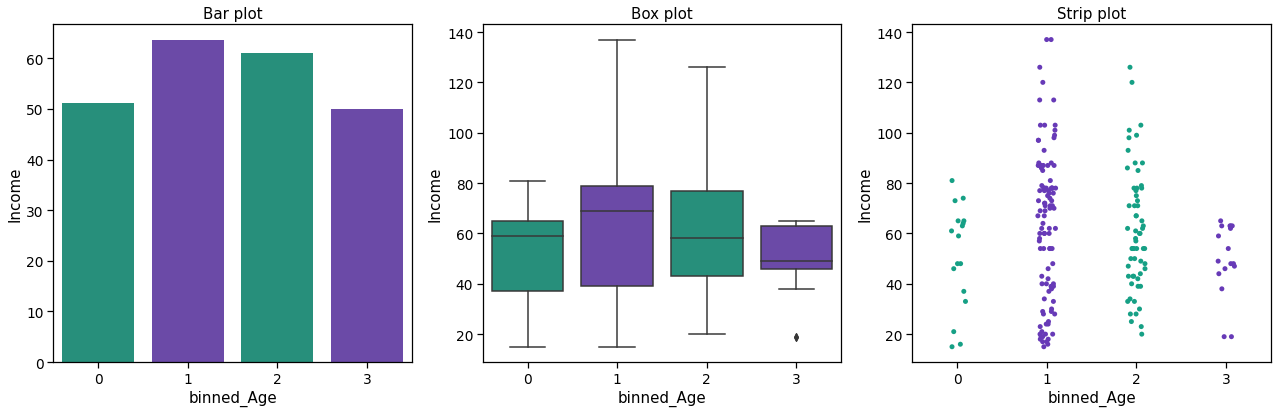

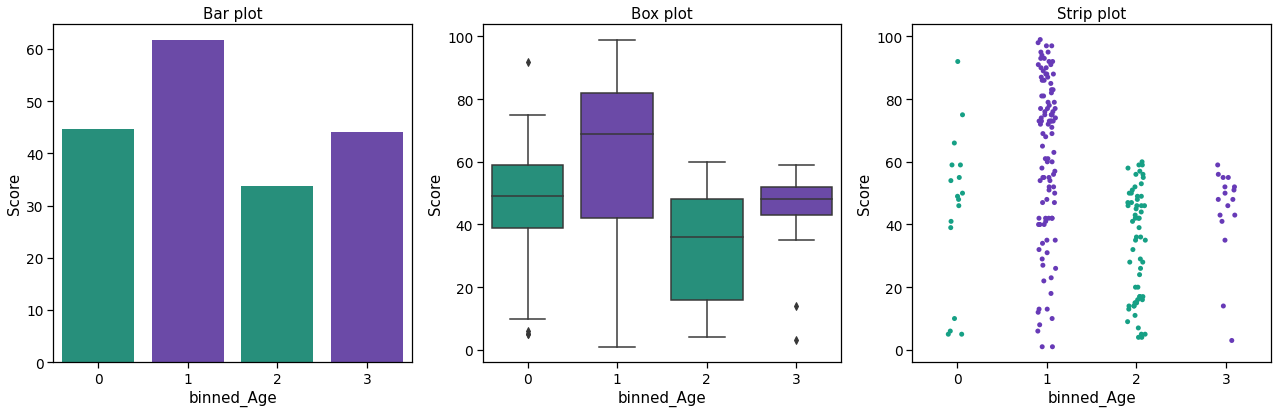

In [67]:
for i, col in enumerate(cols):
    fig=plt.figure(figsize=(18,6))
    ax=plt.subplot(1,3,1)
    temp=df.groupby('binned_Age')[col].mean().reset_index()
    sns.barplot(data=temp,x='binned_Age',y=col,palette=['#16A085','#673AB7']);
    plt.title("Bar plot",fontsize=15)
    ax=plt.subplot(1,3,2)
    sns.boxplot(data=df,x='binned_Age',y=col,palette=['#16A085','#673AB7']);
    plt.title("Box plot",fontsize=15)
    ax=plt.subplot(1,3,3)
    sns.stripplot(data=df,x='binned_Age',y=col,palette=['#16A085','#673AB7']);
    plt.title("Strip plot",fontsize=15)
    plt.tight_layout()

# K-Means

> **Determine the k using Elbow Method through within cluster mean sum of square**

>> After k=5, the mean sum of squared decreases at a lower rate. Therefore, k=5 gives us a good balance between number of clusters to form and inertia.

In [82]:
# Determine the k using Elbow Method
# within-cluster sum of square
wcss = []
x = df[['Income','Score','binned_Age']].values
for i in range(1,15):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter = 300)
    kmeans.fit(x)
    wcss.append(kmeans.inertia_)

Text(0, 0.5, 'Sum of Square')

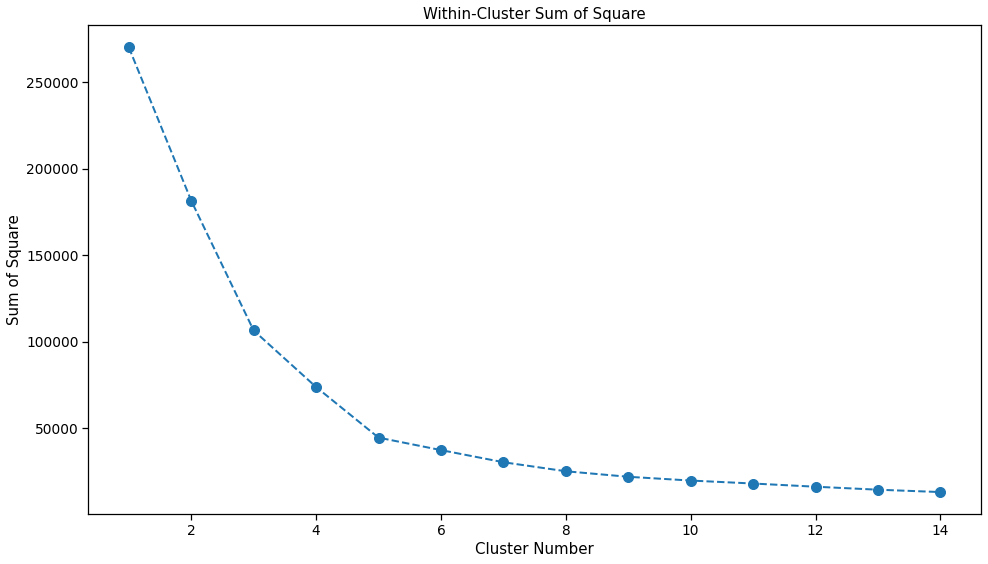

In [93]:
plt.figure(figsize = (16,9))
plt.plot(np.arange(1,15,1), wcss, linestyle='dashed',marker='o', lw=2,ms=10)
plt.title("Within-Cluster Sum of Square")
plt.xlabel("Cluster Number")
plt.ylabel("Mean Sum of Square")

In [95]:
k_means=KMeans(n_clusters=5,init='k-means++',max_iter=500)
y=k_means.fit_predict(x)

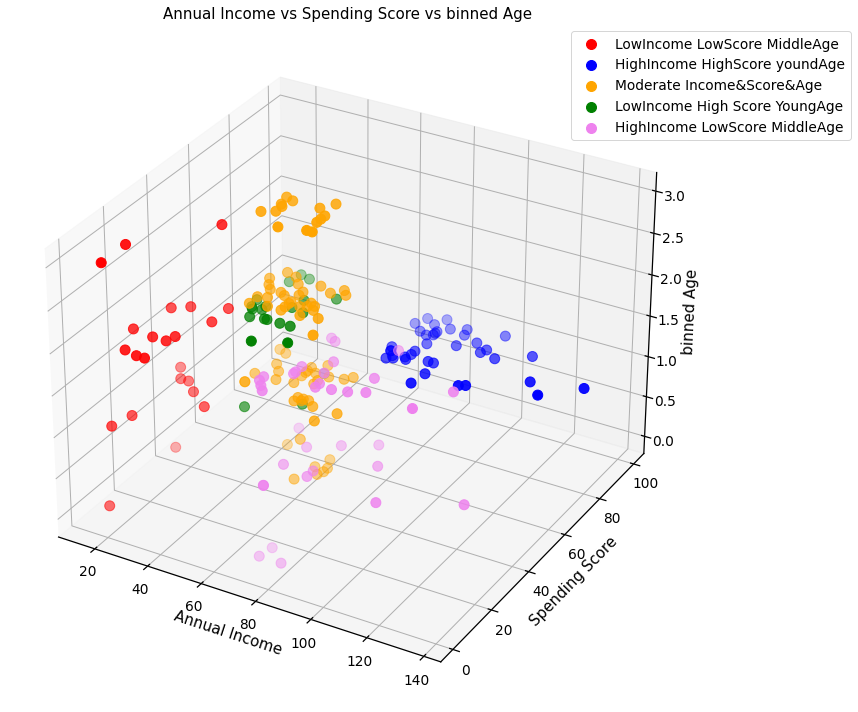

In [109]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection = '3d')
ax.set_xlabel("Annual Income")
ax.set_ylabel("Spending Score")
ax.set_zlabel("binned Age")
ax.set_title("Annual Income vs Spending Score vs binned Age")
ax.scatter(x[y==0,0],x[y==0,1],x[y==0,2],s=100,color='red',label='LowIncome LowScore MiddleAge')
ax.scatter(x[y==1,0],x[y==1,1],x[y==1,2],s=100,color='blue',label='HighIncome HighScore youndAge')
ax.scatter(x[y==2,0],x[y==2,1],x[y==2,2],s=100,color='orange',label='Moderate Income&Score&Age')
ax.scatter(x[y==3,0],x[y==3,1],x[y==3,2],s=100,color='green',label='LowIncome High Score YoungAge')
ax.scatter(x[y==4,0],x[y==4,1],x[y==4,2],s=100,color='violet',label='HighIncome LowScore MiddleAge')
plt.legend(bbox_to_anchor=(1.25,1.0));
plt.tight_layout()
plt.show()

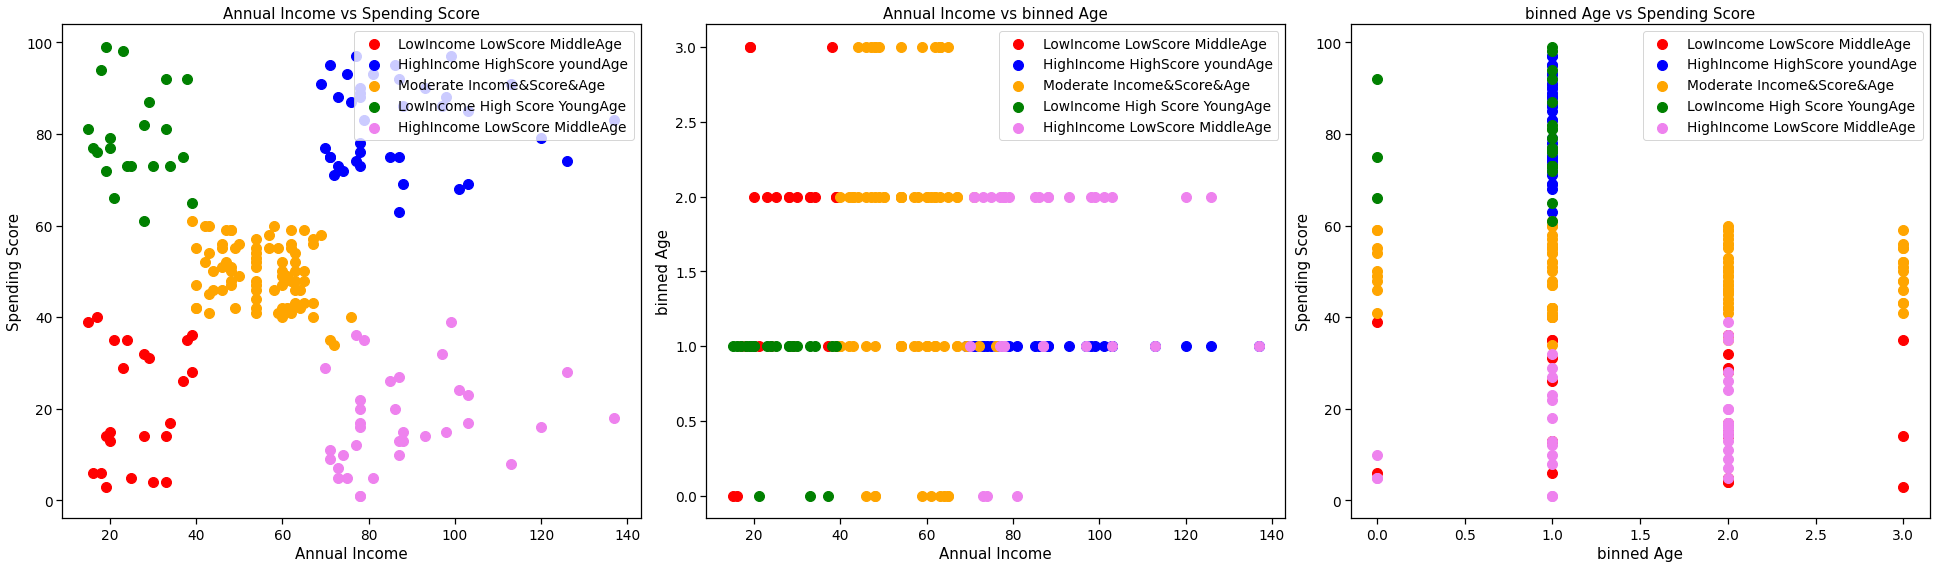

In [108]:
%matplotlib inline
fig = plt.figure(figsize=(27,8))

def plot_2d(x1,y1,xlabel,ylabel,i):
    ax = plt.subplot(1,3,i)
    ax.set_xlabel(f"{xlabel}")
    ax.set_ylabel(f"{ylabel}")
    ax.set_title(f"{xlabel} vs {ylabel}")
    ax.scatter(x[y==0,x1],x[y==0,y1],s=100,color='red',label='LowIncome LowScore MiddleAge')
    ax.scatter(x[y==1,x1],x[y==1,y1],s=100,color='blue',label='HighIncome HighScore youndAge')
    ax.scatter(x[y==2,x1],x[y==2,y1],s=100,color='orange',label='Moderate Income&Score&Age')
    ax.scatter(x[y==3,x1],x[y==3,y1],s=100,color='green',label='LowIncome High Score YoungAge')
    ax.scatter(x[y==4,x1],x[y==4,y1],s=100,color='violet',label='HighIncome LowScore MiddleAge')
    ax.legend(loc = 'upper right')
    plt.tight_layout()
#     plt.show()
    
plot_2d(0,1,"Annual Income",'Spending Score',1)
plot_2d(0,2,"Annual Income",'binned Age',2)
plot_2d(2,1,"binned Age",'Spending Score',3)